In [1]:
import pandas as pd
#import pylab
#import scipy
import matplotlib.pyplot as plt
import matplotlib #so I can call next line
matplotlib.style.use('ggplot')
# import seaborn as sns
import numpy as np

#visuals
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format #7,123,001.34
#'{:20,.2f}'.format #change pandas display format
pd.options.display.max_rows = 20 
#pd.get_option("display.max_rows")


#from __future__ import division #so I can have float as std and int as //

In [2]:
#in-memory grep implementation, filter lines starting wth filterKeyword
#return text string - memory hungry but fast
#http://stackoverflow.com/questions/10717504/is-it-possible-to-use-read-csv-to-read-only-specific-lines
def SimpleLineGrep(ASCIIfileName,filterKeyword):
  try:
    from StringIO import StringIO
  except ImportError:
    from io import StringIO
  s = StringIO()

  with open(ASCIIfileName) as f:
      for line in f:
          if line.startswith(filterKeyword):
              s.write(line)
  s.seek(0) # "rewind" to the beginning of the StringIO object

  return s

<img src=".\pics\GRACE_UoN.png" alt="Drawing" style="width: 200px;"/>

# GNSS RAW ranges in Android N
## Lukasz K Bonenberg


This notebook explains how to calculate pseudo-ranges (code measurments) obtainable from the Android API 24+. This is python implementation of `ProcessGnssMeas.m` Matlab routine from [Google's GPS Measurement Tools](https://github.com/google/gps-measurement-tools).
**It only looks at GPS L1 observations.**


## RAW GNSS data

`android.location` provide following information:


* Position, Velocity and Time (PVT) internal solution; 
* Accumulated Delta Range (Carrier);
* Doppler;
* SNR, observation uncertainty, flags;
* **HW clocks** that we can use to calculate **Pseudorange/Pseudorange Rate** (code);

Apart from the last item, information can be used as it is. This notebook demonstrate how to clalculate pseudoranges by comparing satelite and receiver clocks.

The position that we are trying to calculate is based on GNSS (GPS) signal and can be simplified to:

<img src=".\pics\Terry_GPS_nav01.jpg" alt="Drawing" style="width: 400px;"/>

* By comparing local and satelite clock user measures distance (corrupted with errors, hence name pseudorange) to at least four satellites;
* We obtain/caluclate satellite position and clock corrections (almanach) at the time of transmission either directly from satelite or from internet;
* We use this information to solve for our position and **clock error** using iterative LSA (or in more advanced approach EKF)


## RAW measurments Workflow

* get [time of the week (TOW)](https://www.oc.nps.edu/oc2902w/gps/timsys.html) 
    -  wait unitl at least one satelite can provide it (watch flags), get it from internet or have prior knowledge of it from phone
* start estimating local GPS time at 1s interval
    - make sure you have proper time offset between UTC and GPS time if you calculate it yourself
    - estimate from measurments
    - remeber internal clock runs on GPS and other GNSS systems are just using offsets not intependent time frames (especially watch GLO)
* read data from API
    * calculate pseudorange (L) as difference between the clocks but as mod(x,ns)
    * get all other measurments as they are
    * check the flags ect ect
* calculate PVT for the user


Let's look at the details then.


## Get relevant data

I am simplifying problem by:

* using pre-recorded data
* reducting constellation to GPS only, utilising information from [Android GNSS status API](https://developer.android.com/reference/android/location/GnssStatus.html).

In [3]:
# reads GNSSLogger log file into pandas data frame using Google Logger 2.0
def readGNSSLogger (data_file):
  print("filtering PR from %s" % data_file)
  RawMeas = SimpleLineGrep(data_file,'Raw')
  # for 7.0 
  #colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType","AgcDb","CarrierFrequencyHz"]
  # for 8.0
  # colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType","AgcDb","CarrierFrequencyHz"]
  colNames = ["Raw","ElapsedRealtimeMillis","TimeNanos","LeapSecond","TimeUncertaintyNanos","FullBiasNanos","BiasNanos","BiasUncertaintyNanos","DriftNanosPerSecond","DriftUncertaintyNanosPerSecond","HardwareClockDiscontinuityCount","Svid","TimeOffsetNanos","State","ReceivedSvTimeNanos","ReceivedSvTimeUncertaintyNanos","Cn0DbHz","PseudorangeRateMetersPerSecond","PseudorangeRateUncertaintyMetersPerSecond","AccumulatedDeltaRangeState","AccumulatedDeltaRangeMeters","AccumulatedDeltaRangeUncertaintyMeters","CarrierFrequencyHz","CarrierCycles","CarrierPhase","CarrierPhaseUncertainty","MultipathIndicator","SnrInDb","ConstellationType"]  
  dataFrame = pd.read_csv(RawMeas, delimiter = ",",error_bad_lines=False,header=None,
                          usecols=range(1,len(colNames)),names= colNames,
                          encoding = 'utf-8-sig',na_values = ["NULL",""],engine ='c')
  return dataFrame

def BasicInfo(AndroidData):

  listOfSV = AndroidData.Svid.unique()
  listOfConstelations = AndroidData.ConstellationType.unique()
  GNSS_Constelations = {1:'GPS',2:'SBAS',3:'GLONASS',4:'QZSS',5:'BeiDou',6:'Galileo'}

  print('Observing the following SVs:{}\nusing following constelations: {}\n'.format(
      ','.join(map(str,listOfSV)),','.join([GNSS_Constelations[s] for s in listOfConstelations])))

##################################

    
data_file = "./sampleData/s8_01.txt"
df_GNSS = readGNSSLogger(data_file)
#cut noisy start of data, I just assume that after that all flags are correct
#I should observe flags instead
df_GNSS = df_GNSS[1500:] 
df_GNSS.head()

BasicInfo(df_GNSS)
#get only GPS
df_GPS = df_GNSS[df_GNSS.ConstellationType==1]
BasicInfo(df_GPS)

filtering PR from ./sampleData/s8_01.txt
Observing the following SVs:2,11,22,6,12,14,24,25,29,31,32,13,16,15,5,23,17,7,8,97
using following constelations: Galileo,GPS,GLONASS,BeiDou

Observing the following SVs:2,6,12,14,24,25,29,31,32
using following constelations: GPS



## Calculate pseudoranges

I am simplifying problem by assuming that all GNSS RAW measurments are being read

I will: 

* estimate TOW from measurments
* diff clocks, substract corrections and known TOW to estimate pseudorange in [ns]
    1. traditional approach is to diff and to correct for clock drift later
    1. Paolo approach is to just diff observations at mod(100milis=$10^{-1}s$) and worry about epochs later. THis approach is especially useful as it can estimate ranges from Galileo `2nd code lock state` (which previous approach can't do).
* convert to [m] using GPS defined constant


### Pseudorange (L) is:

* One-way range (distance) between satellite and receiver
* Measurement of time-of-flight of coded signals
* time difference between satellite and the receiver

Defined as $L = \frac{T_{receiver \atop arrival}
-T^{satellite \atop transmission}}{c}$.

where

* receiver clock [ns] is calculated from `public long getTimeNanos()`
* received GNSS satelite time [ns]  is calculated from `public long getReceivedSvTimeNanos()`

**To be more precise**

* from `GnssMeasurementEvent.Callback` we are obtaining:
  * GnssClock
    *  +`getTimeNanos()` - receiver (local) internal hardware clock clock [ns], changes of 1 sec
+/- 1 msec (~every 15min) every epoch
    * -`getFullBiasNanos()` referenced to GPS starting epoch (0000Z, January 6, 1980)
    * -`getBiasNanos()` for sub-ns accuracy, usually 0
    * -`getTimeOffsetNanos()` estimated hardware related delays
  * Collection<GnssMeasurements>
    * +`getReceivedSvTimeNanos()` - satellite clock, referenced to GPS Week (TOW)
* all values in [ns]
* anything within 1ms is considered the same epoch
* DriftNanosPerSecond, DriftUncertaintyNanosPerSecond, LeapSecond, TimeUncertaintyNanos are
usually not available

#### Why use nanoseconds as a unit?

A traditional approach defines GPS time as a combination of GPS week and time of the week. This is not possible with AGPS, used in mobile phones, as we obtain ranges (using mobile tower clocks for corrections to local oscillator and internet for ephemerides) before TOW is set. Hence we always need to express pseudoranges as a mix of clocks. To avoid ambiguity, our local clock (in ns) has to be referenced to GPS starting epoch (0000Z, January 6, 1980). This creates a risk of memory/calculation problem, so we are trying to reduce this value (by subtracting current TOW value) before conducting more complex calculations.

#### Implementation issues

* I am using 64bit floats, might need to use 64bit ints for better calcuation accuracy
* This code assumes single frequency, in dual frequency implementation make sure to consider that:
    * not every GPS satelite transmit L5
    * every Gal satelite transmit E1 and E5, so we need variable for both per satelite

In [4]:
#we operate in [ns=1e-9] so as [100milisec=decsec=1e-1] [decsec]=1e8[ns]
GNSS_const = {'totalWeekSecs':7*24*3600,'lightSpeed':299792458,'ds':1e8
             ,'GPSday':24*60*60,'GPSweek':7*24*60*60 } #constants

#get TOW
GPSWeek = (-df_GPS.FullBiasNanos*1e-9/GNSS_const['totalWeekSecs']).astype('int')
print('GPS week {} '.format(GPSWeek.unique()[0])) #get array of 1 which autocast to integer
#lazy check to verify that each epoch gives me correct TOW, don't use in working code

#calculate tRx and tTx, NOTE df_GPS.FullBiasNanos.iloc[0] is only taken once
tRx_ns  = df_GPS.TimeNanos+df_GPS.TimeOffsetNanos-df_GPS.FullBiasNanos.iloc[0]-(GPSWeek*GNSS_const['totalWeekSecs']*1e9)    
tTx_ns = df_GPS.ReceivedSvTimeNanos


#and now we got two options for PR(L)
##1
PR_m = (tRx_ns-tTx_ns)*GNSS_const['lightSpeed']*1e-9
print(PR_m.head(n=10)) 
#20-22k km? fist readin is way off, looks like a clock jump or wrong flag 

##2 - suggested by Paolo
PR_m = (tRx_ns % GNSS_const['ds'] - tTx_ns% GNSS_const['ds'])*GNSS_const['lightSpeed']*1e-9
print('\n')
PR_m.head(n=10)
#20-23k km? First results are not incorrect, but LSA would at least coverge
# worth checking flags 

GPS week 1946 
1503   66,794,657,563,158.60
1504           23,328,151.66
1505           20,693,591.72
1506           22,875,283.37
1507           22,508,375.48
1508           20,525,751.12
1509           21,997,156.79
1510           23,707,396.91
1511           22,669,157.47
1527   66,794,957,355,541.05
dtype: float64




1503   28,522,630.39
1504   23,328,151.66
1505   20,693,591.72
1506   22,875,283.37
1507   22,508,375.48
1508   20,525,751.12
1509   21,997,156.79
1510   23,707,396.91
1511   22,669,157.47
1527   28,522,554.85
dtype: float64

## estimating epoch of observation

We need to estimate epoch time in order to properly decode corrections and orbits. In Google code, they use two values:

* `gpsTime` in seconds of the week, with ranges of 0-604800s
* `fctSeconds` in seconds since 1980/6/1 0:00:00, with their defined ranges of 0-3786480000s that is until 2100/1/1

Traditional GPS approach is `gpsTime` and this is what we are going to use. This is de-facto `tRx_ns` while taking care of the clock drift (go to nearest second)


In this example we are ignoring:
 
* conversion to UTC and handling of leap seconds (see `Fct2Ymdhms` in Google code) - we will work in * accomodate for the clock drift logic


All RAW measurments, including pseudoranges we just calculated, has to be presented per SV per epoch. We need to:

* calculate each epoch (anything within 1ms is considered the same epoch)
	* compute full cycle time of measurement, in milliseconds (see `ReadGnssLogger.m`)
* obtain SV range for each epoch per satellite

In [56]:
import datetime

#UTC_offset as valid for Feb'19
def covertGPSTimetoUTC(GPSseconds,GPSWeek,UTC_offset=18):

  GPS0 = datetime.datetime(1980, 1, 6)
  weekID = datetime.timedelta(weeks =int(GPSWeek))
  weekSeconds = datetime.timedelta(seconds = round(GPSseconds)) 
  #round to nearest due to clock drift
  UTC_offset= datetime.timedelta(seconds = UTC_offset) 


  #so time is
  epoch = GPS0 + weekID +  weekSeconds - UTC_offset
  return epoch


In [54]:
listOfSV = df_GPS.Svid.unique() #all SV that I see during the period
allRxSec = tRx_ns.values*1e-9;
GPSepochs=allRxSec[0::len(listOfSV)] #note that values are in floats

#so we don't repeat epochs, on normal runs you can just use a tag 
# from a sigle SV

print("Our time is corrupted by clock drift so we can't use it directly, for ex:")
for epoch in GPSepochs[:5]:
    print("{TOW:f}".format(GPSweek=GPSWeek.values[1] ,TOW=epoch))


print('''
Instead we want to round our observations to the nearest epoch. This will only work for 
2.PR generation as we disregard running clock. For the 1. we need to calculate offset and 
add it to our clocks by hand.

To demonstrate 2. approach lets first demonstrate how the observation should be tagged internally,
that is in week and seconds of week, that is:
''')

for epoch in GPSepochs[:5]:
    print("{GPSweek}\t{TOW:.0f}".format(GPSweek=GPSWeek.values[1] ,TOW=epoch))
    
print("\n\nFor display purpose (user) we present time in UT, that is:")
for epoch in GPSepochs[:5]:
    print(covertGPSTimetoUTC(epoch,GPSWeek.values[1]))

Our time is corrupted by clock drift so we can't use it directly, for ex:
222802.999672
222803.999672
222804.999672
222805.999672
222806.999672

Instead we want to round our observations to the nearest epoch. This will only work for 
2.PR generation as we disregard running clock. For the 1. we need to calculate offset and 
add it to our clocks by hand.

To demonstrate 2. approach lets first demonstrate how the observation should be tagged internally,
that is in week and seconds of week, that is:

1946	222803
1946	222804
1946	222805
1946	222806
1946	222807


For display purpose (user) we present time in UT, that is:
2017-04-25 13:53:05
2017-04-25 13:53:06
2017-04-25 13:53:07
2017-04-25 13:53:08
2017-04-25 13:53:09


And just to visualise L1 pseudoranges per satelite

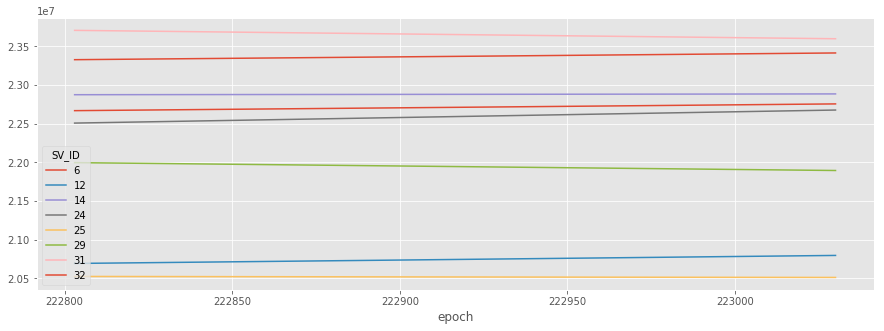

In [7]:
df_PR =pd.DataFrame({'epoch': allRxSec,'SV_ID': df_GPS.Svid,'PR': PR_m})
df_PR =df_PR[df_PR.SV_ID !=2] #remove this SV
SV_ranges = df_PR.pivot(index='epoch',columns='SV_ID', values='PR')
SV_ranges.plot(figsize=[15,5]);

# practical elements


Code below dicuss the more advanced aspects of processing. MARCIN- IGNORE FOR NOW

## Confirming validity of the data

To obtain second level TTFF smartphone GNSSe use measurements long before TOW is decoded using AGPS.  These measurements are considered invalid in traditional GNSS understanding. To confirm with the traditional approach we should only use the ranges with TOW set (1st and 3rd-bit set). For more information check GPS HAL - *gps.h*.
To demonstrate this test logic:


In [8]:
print("""First let's demonstrate how bitwise operations work. 
        To set 1st bit(CODE_LOCK){:#010b}, to set 4th bit(TOW_DECODED){:#010b}
        To set both we need {:#010b}""".
      format(1<<0,1<<3,(1<<3) | (1<<0)))

First let's demonstrate how bitwise operations work. 
        To set 1st bit(CODE_LOCK)0b00000001, to set 4th bit(TOW_DECODED)0b00001000
        To set both we need 0b00001001


Now let's use the same principle to check the flags from the recorded data

In [9]:
state = df_GNSS.State.iloc[0]
print('\nRecorded state {0} can be wrote binary as: {0:#010b}'.format(state))
print('Allowing us to check if TOW flag set: {}'.format((state & (1 << 0))!=0 and (state & (1 << 3))!=0)) 


Recorded state 1074 can be wrote binary as: 0b10000110010
Allowing us to check if TOW flag set: False


## Time accuracy

* `getBiasUncertaintyNanos()` for the clock's Bias Uncertainty (1-Sigma) in nanoseconds. Usualy 20ns if fix, or ~$2^{e-9}$ns (2s) before.
* `getTimeUncertaintyNanos()` for the hardware clock's time Uncertainty (1-Sigma) in nanoseconds. This tends to be 0.


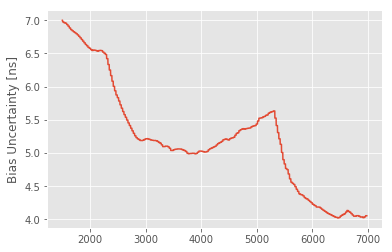

In [10]:
df_GNSS.BiasUncertaintyNanos.plot()
plt.ylabel('Bias Uncertainty [ns]');


## Problems with the accuracy of calculations

Pandas will automaticaly determine best type of variables to use. As discussed before with large numbers we might still end up with calculation errors due to rounding (float point calculation). Example below demonstrate the problem.


In [11]:
print(df_GNSS.dtypes)

ElapsedRealtimeMillis                       int64
TimeNanos                                   int64
LeapSecond                                float64
TimeUncertaintyNanos                      float64
FullBiasNanos                               int64
BiasNanos                                 float64
BiasUncertaintyNanos                      float64
DriftNanosPerSecond                       float64
DriftUncertaintyNanosPerSecond            float64
HardwareClockDiscontinuityCount             int64
                                           ...   
AccumulatedDeltaRangeState                  int64
AccumulatedDeltaRangeMeters               float64
AccumulatedDeltaRangeUncertaintyMeters    float64
CarrierFrequencyHz                        float64
CarrierCycles                             float64
CarrierPhase                              float64
CarrierPhaseUncertainty                   float64
MultipathIndicator                          int64
SnrInDb                                   float64


In [12]:
def CheckCalculus(number):

  y=number-1
  z=number-1+1
  print('Checking for floating poing overflow, it should be 1 and 0\nx-y={:}\nz-x={:}'.format(number-y,number-z))

In [13]:
x=-1151285108458178048
CheckCalculus(x)
CheckCalculus(x*100000)

CheckCalculus(x*1e3) #hidden cast to float
CheckCalculus(x*1.0) #float


#import decimal as dec


Checking for floating poing overflow, it should be 1 and 0
x-y=1
z-x=0
Checking for floating poing overflow, it should be 1 and 0
x-y=1
z-x=0
Checking for floating poing overflow, it should be 1 and 0
x-y=0.0
z-x=0.0
Checking for floating poing overflow, it should be 1 and 0
x-y=0.0
z-x=0.0


A careful approach is needed to avoid this calculation problem. Also check those additional resources:

* <http://mpmath.org/>

# Some helpful links

* [Google code](https://github.com/google/gps-measurement-tools) - this is the official code from Google, in Matlab.
* [my version of GPS Measurement tools](https://github.com/DfAC/gps-measurement-tools), mostly added notes and small changes simplifying the use of script.
* [this repo](https://github.com/DfAC/AndroidGNSS)


* [useful comments on pandas](d:\tmp\Dropbox\Edu\ION_GNSS\AndroidGNSS\)
* [bitwise operations in python](https://wiki.python.org/moin/BitwiseOperators)
* [format string](https://docs.python.org/3/library/string.html)
* [format output](https://pyformat.info)
* [Rokybun blog](http://rokubun.cat/2016/06/30/android-n-preview-gnss-measurements/)
* [BlackDotGNSS blog](http://www.blackdotgnss.com/2016/09/20/ppp-with-smartphones-are-we-there-yet/)
